# Loading the python packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set()
import graphviz
from scipy.stats import rankdata
import pickle
import scipy.stats as stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Extracting training data

In [3]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)
sp500_df = sp500_table[0]
symbols = sp500_df['Symbol'].tolist()

In [4]:
import yfinance as yfin
def get(tickers, start, end):
    def multiple(ticker):
        return yfin.download(ticker, start, end, progress=False)
    datas = map(multiple, tickers)
    return pd.concat(datas, keys=tickers,names=['Ticker', 'Date'])

extract training data

In [5]:
if not os.path.exists('raw_ohlcv.csv'):
    print("File does not exist, starting download...")
    tickers = symbols
    start = pd.to_datetime('2017-01-01')
    end = pd.to_datetime('2019-12-31')
    raw_ohlcv = get(tickers, start, end)
    raw_ohlcv.to_csv('raw_ohlcv.csv')
else:
    print("File already exists, skipping download.")

File does not exist, starting download...



1 Failed download:
['ABNB']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2017-01-01 00:00:00 -> 2019-12-31 00:00:00)')

1 Failed download:
['CARR']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['OTIS']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1577768400")

1 Failed download:
['VLTO']: Exce

# Preprocessing data

In [6]:
raw_ohlcv = pd.read_csv('raw_ohlcv.csv')
raw_ohlcv = raw_ohlcv.set_index('Date')
raw_ohlcv

Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2017-01-03    MMM  178.830002  180.000000  177.220001  178.050003  138.587036   
2017-01-04    MMM  178.029999  178.899994  177.610001  178.320007  138.797226   
2017-01-05    MMM  178.259995  179.139999  176.889999  177.710007  138.322449   
2017-01-06    MMM  177.289993  178.600006  175.800003  178.229996  138.727142   
2017-01-09    MMM  178.369995  178.380005  177.199997  177.270004  137.979980   
...           ...         ...         ...         ...         ...         ...   
2019-12-23    ZTS  132.710007  133.059998  131.389999  132.369995  128.766769   
2019-12-24    ZTS  132.210007  133.080002  131.289993  132.919998  129.301788   
2019-12-26    ZTS  133.190002  133.190002  132.320007  133.029999  129.408783   
2019-12-27    ZTS  133.399994  133.479996  132.380005  133.250000  129.622818   
2019-12-30    ZTS  133.570007  133.660004  131.809998  132.210007  128.611145   

               Volume  
Date                   
2017-01-03  2509300.0  
2017-01-04  1542000.0  
2017-01-05  1447800.0  
2017-01-06  1625000.0  
2017-01-09  1622600.0  
...               ...  
2019-12-23  1632300.0  
2019-12-24   442500.0  
2019-12-26   929400.0  
2019-12-27  1296100.0  
2019-12-30   942000.0  

[368550 rows x 7 columns]

## preprocess training features and targets for gplearn

Create a data processor for GP factor mining 

In [7]:
class gp_preprocessor:
    def __init__(self):
        pass

    def extract_original_features(self,raw_data):
        return raw_data.loc[:,['Ticker','Open','High','Low','Volume','Adj Close']]
    
    def add_lagging_features(self,data,ts=False):
        fields = ['Open','High','Low','Volume','Adj Close']
        for feature in ['Open','High','Low','Volume','Adj Close']:
            for lagging_days in [1,3,5,10,20]:
                data[feature+'_Lag'+str(lagging_days)] = data.groupby('Ticker')[feature].shift(lagging_days)
                fields.append(feature+'_Lag'+str(lagging_days))
                if ts:
                    data[feature+'_ts'+str(lagging_days)] = data.groupby('Ticker')[feature].transform(lambda x: x.rolling(window=10).mean())
                    fields.append(feature+'_ts'+str(lagging_days))
        return data, fields
    
    def calculate_targets(self,data):
        data['Future_20d_Adj Close'] = data.groupby('Ticker')['Adj Close'].shift(-5)
        data['Future_20d_Return'] = (data['Future_20d_Adj Close'] - data['Adj Close']) / data['Adj Close']
        return data

In [8]:
train_data = gp_preprocessor().extract_original_features(raw_ohlcv)
train_data

Ticker        Open        High         Low     Volume   Adj Close
Date                                                                        
2017-01-03    MMM  178.830002  180.000000  177.220001  2509300.0  138.587036
2017-01-04    MMM  178.029999  178.899994  177.610001  1542000.0  138.797226
2017-01-05    MMM  178.259995  179.139999  176.889999  1447800.0  138.322449
2017-01-06    MMM  177.289993  178.600006  175.800003  1625000.0  138.727142
2017-01-09    MMM  178.369995  178.380005  177.199997  1622600.0  137.979980
...           ...         ...         ...         ...        ...         ...
2019-12-23    ZTS  132.710007  133.059998  131.389999  1632300.0  128.766769
2019-12-24    ZTS  132.210007  133.080002  131.289993   442500.0  129.301788
2019-12-26    ZTS  133.190002  133.190002  132.320007   929400.0  129.408783
2019-12-27    ZTS  133.399994  133.479996  132.380005  1296100.0  129.622818
2019-12-30    ZTS  133.570007  133.660004  131.809998   942000.0  128.611145

[368550 rows x 6 columns]

add lagging features for time series

In [9]:
train_data, fields = gp_preprocessor().add_lagging_features(train_data)
train_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2017-01-03    MMM  178.830002  180.000000  177.220001  2509300.0  138.587036   
2017-01-04    MMM  178.029999  178.899994  177.610001  1542000.0  138.797226   
2017-01-05    MMM  178.259995  179.139999  176.889999  1447800.0  138.322449   
2017-01-06    MMM  177.289993  178.600006  175.800003  1625000.0  138.727142   
2017-01-09    MMM  178.369995  178.380005  177.199997  1622600.0  137.979980   
...           ...         ...         ...         ...        ...         ...   
2019-12-23    ZTS  132.710007  133.059998  131.389999  1632300.0  128.766769   
2019-12-24    ZTS  132.210007  133.080002  131.289993   442500.0  129.301788   
2019-12-26    ZTS  133.190002  133.190002  132.320007   929400.0  129.408783   
2019-12-27    ZTS  133.399994  133.479996  132.380005  1296100.0  129.622818   
2019-12-30    ZTS  133.570007  133.660004  131.809998   942000.0  128.611145   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag1  \
Date                                                        ...                
2017-01-03         NaN         NaN         NaN         NaN  ...          NaN   
2017-01-04  178.830002         NaN         NaN         NaN  ...    2509300.0   
2017-01-05  178.029999         NaN         NaN         NaN  ...    1542000.0   
2017-01-06  178.259995  178.830002         NaN         NaN  ...    1447800.0   
2017-01-09  177.289993  178.029999         NaN         NaN  ...    1625000.0   
...                ...         ...         ...         ...  ...          ...   
2019-12-23  129.380005  127.150002  125.000000  121.489998  ...    5320300.0   
2019-12-24  132.710007  127.629997  126.720001  122.000000  ...    1632300.0   
2019-12-26  132.210007  129.380005  127.150002  123.199997  ...     442500.0   
2019-12-27  133.190002  132.710007  127.629997  123.690002  ...     929400.0   
2019-12-30  133.399994  132.210007  129.380005  123.949997  ...    1296100.0   

            Volume_Lag3  Volume_Lag5  Volume_Lag10  Volume_Lag20  \
Date                                                               
2017-01-03          NaN          NaN           NaN           NaN   
2017-01-04          NaN          NaN           NaN           NaN   
2017-01-05          NaN          NaN           NaN           NaN   
2017-01-06    2509300.0          NaN           NaN           NaN   
2017-01-09    1542000.0          NaN           NaN           NaN   
...                 ...          ...           ...           ...   
2019-12-23    2754200.0    1391100.0     1570800.0     1627700.0   
2019-12-24    2055700.0    1994800.0     2047000.0     1774400.0   
2019-12-26    5320300.0    2754200.0     1803000.0     3688700.0   
2019-12-27    1632300.0    2055700.0     2041800.0     1443300.0   
2019-12-30     442500.0    5320300.0     1130100.0     1064400.0   

            Adj Close_Lag1  Adj Close_Lag3  Adj Close_Lag5  Adj Close_Lag10  \
Date                                                                          
2017-01-03             NaN             NaN             NaN              NaN   
2017-01-04      138.587036             NaN             NaN              NaN   
2017-01-05      138.797226             NaN             NaN              NaN   
2017-01-06      138.322449      138.587036             NaN              NaN   
2017-01-09      138.727142      138.797226             NaN              NaN   
...                    ...             ...             ...              ...   
2019-12-23      129.068298      123.533195      123.017647       117.930008   
2019-12-24      128.766769      125.235588      123.640221       119.437813   
2019-12-26      129.301788      129.068298      123.533195       120.196587   
2019-12-27      129.408783      128.766769      125.235588       120.945610   
2019-12-30      129.622818      129.301788      129.068298       121.062340   

            Adj 

calculate targets

In [10]:
train_data = gp_preprocessor().calculate_targets(train_data)
train_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2017-01-03    MMM  178.830002  180.000000  177.220001  2509300.0  138.587036   
2017-01-04    MMM  178.029999  178.899994  177.610001  1542000.0  138.797226   
2017-01-05    MMM  178.259995  179.139999  176.889999  1447800.0  138.322449   
2017-01-06    MMM  177.289993  178.600006  175.800003  1625000.0  138.727142   
2017-01-09    MMM  178.369995  178.380005  177.199997  1622600.0  137.979980   
...           ...         ...         ...         ...        ...         ...   
2019-12-23    ZTS  132.710007  133.059998  131.389999  1632300.0  128.766769   
2019-12-24    ZTS  132.210007  133.080002  131.289993   442500.0  129.301788   
2019-12-26    ZTS  133.190002  133.190002  132.320007   929400.0  129.408783   
2019-12-27    ZTS  133.399994  133.479996  132.380005  1296100.0  129.622818   
2019-12-30    ZTS  133.570007  133.660004  131.809998   942000.0  128.611145   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag5  \
Date                                                        ...                
2017-01-03         NaN         NaN         NaN         NaN  ...          NaN   
2017-01-04  178.830002         NaN         NaN         NaN  ...          NaN   
2017-01-05  178.029999         NaN         NaN         NaN  ...          NaN   
2017-01-06  178.259995  178.830002         NaN         NaN  ...          NaN   
2017-01-09  177.289993  178.029999         NaN         NaN  ...          NaN   
...                ...         ...         ...         ...  ...          ...   
2019-12-23  129.380005  127.150002  125.000000  121.489998  ...    1391100.0   
2019-12-24  132.710007  127.629997  126.720001  122.000000  ...    1994800.0   
2019-12-26  132.210007  129.380005  127.150002  123.199997  ...    2754200.0   
2019-12-27  133.190002  132.710007  127.629997  123.690002  ...    2055700.0   
2019-12-30  133.399994  132.210007  129.380005  123.949997  ...    5320300.0   

            Volume_Lag10  Volume_Lag20  Adj Close_Lag1  Adj Close_Lag3  \
Date                                                                     
2017-01-03           NaN           NaN             NaN             NaN   
2017-01-04           NaN           NaN      138.587036             NaN   
2017-01-05           NaN           NaN      138.797226             NaN   
2017-01-06           NaN           NaN      138.322449      138.587036   
2017-01-09           NaN           NaN      138.727142      138.797226   
...                  ...           ...             ...             ...   
2019-12-23     1570800.0     1627700.0      129.068298      123.533195   
2019-12-24     2047000.0     1774400.0      128.766769      125.235588   
2019-12-26     1803000.0     3688700.0      129.301788      129.068298   
2019-12-27     2041800.0     1443300.0      129.408783      128.766769   
2019-12-30     1130100.0     1064400.0      129.622818      129.301788   

            Adj Close_Lag5  Adj Close_Lag10  Adj Close_Lag20  \
Date                                                           
2017-01-03             NaN              NaN              NaN   
2017-01-04             NaN              NaN              NaN   
2017-01-05             NaN              NaN              NaN   
2017-01-06             NaN              NaN              NaN   
2017-01-09             NaN              NaN              NaN   
...                    ...              ...              ...   
2019-12-23      123.017647       117.930008       116.548668   
2019-12-24      123.640221       119.437813       117.326881   
2019-12-26      123.533195       120.196587       118.572029   
2019-12-27      125.235588       120.945610       118.319122   
2019-12-30      129.068298       121.062340       117.239334   

            Future_20d_Adj Close  Future_20d_Return  
Date                                                 
2017-01-03            137

delete nan

In [11]:
train_data.dropna(axis=0, how='any',inplace=True)
train_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2017-02-01    MMM  175.169998  175.800003  174.300003  2272900.0  136.345352   
2017-02-02    MMM  174.130005  174.779999  173.550003  3106800.0  135.574829   
2017-02-03    MMM  174.020004  175.300003  173.850006  2820500.0  136.244186   
2017-02-06    MMM  174.119995  176.199997  173.899994  1622800.0  136.290909   
2017-02-07    MMM  176.080002  176.399994  175.149994  1247400.0  136.804642   
...           ...         ...         ...         ...        ...         ...   
2019-12-16    ZTS  125.000000  126.500000  124.370003  1391100.0  123.017647   
2019-12-17    ZTS  126.720001  127.360001  125.239998  1994800.0  123.640221   
2019-12-18    ZTS  127.150002  127.629997  126.559998  2754200.0  123.533195   
2019-12-19    ZTS  127.629997  128.889999  127.449997  2055700.0  125.235588   
2019-12-20    ZTS  129.380005  133.520004  128.979996  5320300.0  129.068298   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag5  \
Date                                                        ...                
2017-02-01  174.740005  177.479996  177.089996  177.899994  ...    3462600.0   
2017-02-02  175.169998  177.250000  176.309998  179.250000  ...    2235900.0   
2017-02-03  174.130005  174.740005  177.479996  179.199997  ...    1623700.0   
2017-02-06  174.020004  175.169998  177.250000  177.910004  ...    1823100.0   
2017-02-07  174.119995  174.130005  174.740005  177.500000  ...    1845500.0   
...                ...         ...         ...         ...  ...          ...   
2019-12-16  123.949997  123.199997  121.489998  120.870003  ...    1570800.0   
2019-12-17  125.000000  123.690002  122.000000  119.639999  ...    2047000.0   
2019-12-18  126.720001  123.949997  123.199997  121.010002  ...    1803000.0   
2019-12-19  127.150002  125.000000  123.690002  119.199997  ...    2041800.0   
2019-12-20  127.629997  126.720001  123.949997  121.000000  ...    1130100.0   

            Volume_Lag10  Volume_Lag20  Adj Close_Lag1  Adj Close_Lag3  \
Date                                                                     
2017-02-01     1804600.0     2509300.0      136.073013      138.143417   
2017-02-02     1464400.0     1542000.0      136.345352      136.539978   
2017-02-03     1761900.0     1447800.0      135.574829      136.073013   
2017-02-06     1986800.0     1625000.0      136.244186      136.345352   
2017-02-07     3473200.0     1622600.0      136.290909      135.574829   
...                  ...           ...             ...             ...   
2019-12-16     2050400.0     3429200.0      121.062340      120.196587   
2019-12-17     2115200.0     3023100.0      123.017647      120.945610   
2019-12-18     2566500.0     2349500.0      123.640221      121.062340   
2019-12-19     2771100.0     2142900.0      123.533195      123.017647   
2019-12-20     2387200.0     1654500.0      125.235588      123.640221   

            Adj Close_Lag5  Adj Close_Lag10  Adj Close_Lag20  \
Date                                                           
2017-02-01      137.559631       138.929581       138.587036   
2017-02-02      137.629684       139.077438       138.797226   
2017-02-03      138.143417       138.929581       138.322449   
2017-02-06      136.539978       138.945084       138.727142   
2017-02-07      136.073013       136.968094       137.979980   
...                    ...              ...              ...   
2019-12-16      117.930008       116.645935       114.710114   
2019-12-17      119.437813       117.249054       115.566139   
2019-12-18      120.196587       116.480568       117.054489   
2019-12-19      120.945610       116.840500       116.305466   
2019-12-20      121.062340       118.406662       116.947487   

            Future_20d_Adj Close  Future_20d_Return  
Date                                                 
2017-02-01            137

split features and targets

In [12]:
X_train = train_data.loc[:,fields]
X_train

Open        High         Low     Volume   Adj Close  \
Date                                                                    
2017-02-01  175.169998  175.800003  174.300003  2272900.0  136.345352   
2017-02-02  174.130005  174.779999  173.550003  3106800.0  135.574829   
2017-02-03  174.020004  175.300003  173.850006  2820500.0  136.244186   
2017-02-06  174.119995  176.199997  173.899994  1622800.0  136.290909   
2017-02-07  176.080002  176.399994  175.149994  1247400.0  136.804642   
...                ...         ...         ...        ...         ...   
2019-12-16  125.000000  126.500000  124.370003  1391100.0  123.017647   
2019-12-17  126.720001  127.360001  125.239998  1994800.0  123.640221   
2019-12-18  127.150002  127.629997  126.559998  2754200.0  123.533195   
2019-12-19  127.629997  128.889999  127.449997  2055700.0  125.235588   
2019-12-20  129.380005  133.520004  128.979996  5320300.0  129.068298   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  Open_Lag20  ...  \
Date                                                                    ...   
2017-02-01  174.740005  177.479996  177.089996  177.899994  178.830002  ...   
2017-02-02  175.169998  177.250000  176.309998  179.250000  178.029999  ...   
2017-02-03  174.130005  174.740005  177.479996  179.199997  178.259995  ...   
2017-02-06  174.020004  175.169998  177.250000  177.910004  177.289993  ...   
2017-02-07  174.119995  174.130005  174.740005  177.500000  178.369995  ...   
...                ...         ...         ...         ...         ...  ...   
2019-12-16  123.949997  123.199997  121.489998  120.870003  116.720001  ...   
2019-12-17  125.000000  123.690002  122.000000  119.639999  117.580002  ...   
2019-12-18  126.720001  123.949997  123.199997  121.010002  119.010002  ...   
2019-12-19  127.150002  125.000000  123.690002  119.199997  120.330002  ...   
2019-12-20  127.629997  126.720001  123.949997  121.000000  119.860001  ...   

            Volume_Lag1  Volume_Lag3  Volume_Lag5  Volume_Lag10  Volume_Lag20  \
Date                                                                            
2017-02-01    1845500.0    1623700.0    3462600.0     1804600.0     2509300.0   
2017-02-02    2272900.0    1823100.0    2235900.0     1464400.0     1542000.0   
2017-02-03    3106800.0    1845500.0    1623700.0     1761900.0     1447800.0   
2017-02-06    2820500.0    2272900.0    1823100.0     1986800.0     1625000.0   
2017-02-07    1622800.0    3106800.0    1845500.0     3473200.0     1622600.0   
...                 ...          ...          ...           ...           ...   
2019-12-16    1130100.0    1803000.0    1570800.0     2050400.0     3429200.0   
2019-12-17    1391100.0    2041800.0    2047000.0     2115200.0     3023100.0   
2019-12-18    1994800.0    1130100.0    1803000.0     2566500.0     2349500.0   
2019-12-19    2754200.0    1391100.0    2041800.0     2771100.0     2142900.0   
2019-12-20    2055700.0    1994800.0    1130100.0     2387200.0     1654500.0   

            Adj Close_Lag1  Adj Close_Lag3  Adj Close_Lag5  Adj Close_Lag10  \
Date                                                                          
2017-02-01      136.073013      138.143417      137.559631       138.929581   
2017-02-02      136.345352      136.539978      137.629684       139.077438   
2017-02-03      135.574829      136.073013      138.143417       138.929581   
2017-02-06      136.244186      136.345352      136.539978       138.945084   
2017-02-07      136.290909      135.574829      136.073013       136.968094   
...                    ...             ...             ...              ...   
2019-12-16      121.062340      120.196587      117.930008       116.645935   
2019-12-17      123.017647      120.945610      119.437813       117.249054   
2019-12-18      123.640221      121.062340      120.196587       116.480568   
2019-12-19      123.533195      123.017647      120.945610       116.840500   
2019-12-20      125.235588      123.64

In [13]:
y_train = train_data.loc[:,'Future_20d_Return']
y_train

Date
2017-02-01    0.010847
2017-02-02    0.022965
2017-02-03    0.022624
2017-02-06    0.033810
2017-02-07    0.033227
                ...   
2019-12-16    0.046734
2019-12-17    0.045791
2019-12-18    0.047563
2019-12-19    0.035032
2019-12-20   -0.003542
Name: Future_20d_Return, Length: 356200, dtype: float64

## initialize the function set defined by gplearn

In [14]:
init_function = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','max','min']

## initialize the customized function set

In [15]:
def _cube(data):
    return np.square(data)*data

def _square(data):
    return np.square(data)

In [16]:
cube = make_function(function=_cube, name='cube', arity=1)
square = make_function(function=_square, name='square', arity=1)

In [17]:
user_function = [square, cube]

# Gentic Programming

## initialize the gentic programming model

In [18]:
fields = X_train.columns
function_set = init_function + user_function
population_size = 3000
generations = 3
random_state= 42
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
                            metric='spearman',  # i.e. RankIC
                            population_size=population_size,
                            tournament_size=30, 
                            random_state=random_state,
                            verbose=2,
                            parsimony_coefficient=0.0001,
                            p_crossover = 0.4,
                            p_subtree_mutation = 0.01,
                            p_hoist_mutation = 0,
                            p_point_mutation = 0.01,
                            p_point_replace = 0.4,
                            n_jobs = 6
                         )

## feature engineering

In [19]:
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.1min remaining:  2.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.1min finished


   0    10.34       0.00739207        6        0.0593959              N/A      2.21m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.1min remaining:  2.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.1min finished


   1     8.95        0.0293428        6        0.0601163              N/A      1.08m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.0min remaining:  2.0min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.0min finished


   2     6.13        0.0479801        6        0.0603023              N/A      0.00s


SymbolicTransformer(feature_names=Index(['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Open_Lag1', 'Open_Lag3',
       'Open_Lag5', 'Open_Lag10', 'Open_Lag20', 'High_Lag1', 'High_Lag3',
       'High_Lag5', 'High_Lag10', 'High_Lag20', 'Low_Lag1', 'Low_Lag3',
       'Low_Lag5', 'Low_Lag10', 'Low_Lag20', 'Volume_Lag1', 'Volume_Lag3',
       'Volume_Lag5', 'Volume_Lag10', 'Volume_Lag20', 'Adj Close_Lag1',...
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'max', 'min',
                                  <gplearn.functions._Function object at 0x00000230FC552DA0>,
                                  <gplearn.functions._Function object at 0x00000230FC553370>],
                    generations=3, metric='spearman', n_jobs=6, p_crossover=0.4,
                    p_hoist_mutation=0, p_point_replace=0.4,
                    parsimony_coefficient=0.0001, population_size=3000,
                    random_state=42, tournament_size=30, verbose=2)

In [20]:
average_fitness_per_generation = []
average_length_per_generation = []
for generation in est_gp._programs:
    # select validate fomulas
    valid_programs = [prog for prog in generation if prog is not None]
    if valid_programs:
        average_fitness = np.mean([prog.fitness_ for prog in valid_programs])
        average_fitness_per_generation.append(average_fitness)
        average_length = np.mean([prog.length_ for prog in valid_programs])
        average_length_per_generation.append(average_length)
evolution_process = pd.DataFrame({'average fitness':average_fitness_per_generation,'average length':average_length_per_generation},index=list(range(1,4)))
evolution_process.index.name = 'generation'
evolution_process

average fitness  average length
generation                                 
1                  0.035188        7.968750
2                  0.053338        7.308612
3                  0.047367        6.134000

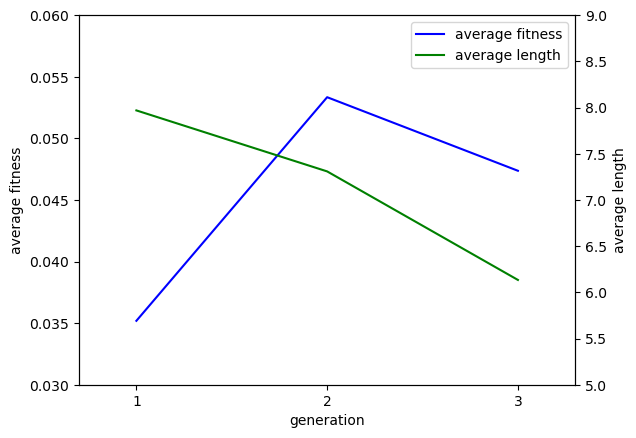

In [21]:
ax = evolution_process['average fitness'].plot(color='blue', label='average fitness')
ax2 = ax.twinx()
evolution_process['average length'].plot(ax=ax2, color='green', label='average length')
ax.set_ylabel('average fitness')
ax2.set_ylabel('average length')

ax.set_ylim(0.03,0.06)
ax2.set_ylim(5,9)
ax.set_xlim([0.7,3.3])
plt.xticks([1, 2, 3])

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
plt.legend(handles, labels, loc='best')
plt.show()

## check the learned features

In [22]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'factor_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
#best_programs_dict = best_programs_dict.sort_values(by='fitness')
#best_programs_dict.to_csv('factor_formulas.csv')
best_programs_dict 

fitness                                         expression depth  \
factor_1   0.059702  sub(div(Open_Lag1, Adj Close_Lag20), inv(High_...     2   
factor_2   0.059134  sub(log(min(div(Open_Lag3, Adj Close_Lag20), m...     4   
factor_3   0.059458  inv(div(Low_Lag5, sub(Low_Lag3, Adj Close_Lag2...     3   
factor_4   0.059196  log(min(div(Open_Lag3, Adj Close_Lag20), div(O...     3   
factor_5   0.059326  sub(div(High_Lag1, Adj Close_Lag20), inv(High_...     2   
factor_6   0.058823  sub(inv(sub(Open_Lag20, div(Open_Lag5, Adj Clo...     4   
factor_7   0.058809  log(min(div(Open_Lag3, Adj Close_Lag20), sub(d...     4   
factor_8   0.059027  inv(sub(div(Open_Lag3, Adj Close_Lag20), inv(H...     3   
factor_9   0.058823  sub(sub(div(High_Lag3, Adj Close_Lag20), inv(H...     3   
factor_10  0.058828  sub(div(High_Lag3, Adj Close_Lag20), inv(Open_...     2   

          length  
factor_1       6  
factor_2      11  
factor_3       6  
factor_4       8  
factor_5       6  
factor_6      11  
factor_7      11  
factor_8       7  
factor_9       9  
factor_10      6

In [23]:
best_programs_dict['fitness'].mean()

0.05911261444285561

In [24]:
factors_data = pd.DataFrame(est_gp.transform(X_train),columns=['factor_'+str(i) for i in range(1,11)])
factors_data

factor_1  factor_2  factor_3  factor_4  factor_5  factor_6  factor_7  \
0       1.255250  0.241741  0.216588  0.231801  1.260445 -1.260431  0.245788   
1       1.256430  0.238921  0.204912  0.232743  1.260969 -1.260939  0.242848   
2       1.253171  0.228012  0.200687  0.230215  1.257870 -1.257919  0.233320   
3       1.248717  0.227560  0.203425  0.226661  1.257943 -1.257950  0.232339   
4       1.256201  0.226972  0.204649  0.232636  1.271275 -1.271350  0.231892   
...          ...       ...       ...       ...       ...       ...       ...   
356195  1.072466  0.063317  0.067147  0.071401  1.078307 -1.077745  0.068008   
356196  1.073632  0.059935  0.064346  0.067935  1.086611 -1.086029  0.067935   
356197  1.074548  0.049214  0.049634  0.057239  1.080016 -1.079563  0.055064   
356198  1.085337  0.064189  0.065358  0.072094  1.089464 -1.088984  0.072094   
356199  1.083493  0.072403  0.067337  0.080255  1.094267 -1.093701  0.078057   

        factor_8  factor_9  factor_10  
0       0.784301  1.273010   1.278524  
1       0.786524  1.269248   1.274792  
2       0.795177  1.257087   1.262743  
3       0.795541  1.255859   1.261489  
4       0.796005  1.255263   1.260962  
...          ...       ...        ...  
356195  0.938149  1.062291   1.070390  
356196  0.941357  1.065632   1.073632  
356197  0.951580  1.048584   1.056741  
356198  0.937338  1.071843   1.079788  
356199  0.929617  1.073332   1.081201  

[356200 rows x 10 columns]

In [25]:
factors_data.corr()

factor_1  factor_2  factor_3  factor_4  factor_5  factor_6  \
factor_1   1.000000  0.865864  0.695712  0.866117  0.998933 -0.511019   
factor_2   0.865864  1.000000  0.921838  0.967261  0.862767 -0.429319   
factor_3   0.695712  0.921838  1.000000  0.944730  0.692350 -0.361933   
factor_4   0.866117  0.967261  0.944730  1.000000  0.863424 -0.449754   
factor_5   0.998933  0.862767  0.692350  0.863424  1.000000 -0.512260   
factor_6  -0.511019 -0.429319 -0.361933 -0.449754 -0.512260  1.000000   
factor_7   0.836116  0.974563  0.887447  0.929099  0.833283 -0.409181   
factor_8  -0.103488 -0.136186 -0.148478 -0.142527 -0.102407  0.046902   
factor_9   0.987004  0.878702  0.682574  0.843071  0.985811 -0.495308   
factor_10  0.993174  0.870423  0.695357  0.859603  0.992643 -0.507694   

           factor_7  factor_8  factor_9  factor_10  
factor_1   0.836116 -0.103488  0.987004   0.993174  
factor_2   0.974563 -0.136186  0.878702   0.870423  
factor_3   0.887447 -0.148478  0.682574   0.695357  
factor_4   0.929099 -0.142527  0.843071   0.859603  
factor_5   0.833283 -0.102407  0.985811   0.992643  
factor_6  -0.409181  0.046902 -0.495308  -0.507694  
factor_7   1.000000 -0.087395  0.855110   0.840562  
factor_8  -0.087395  1.000000 -0.100800  -0.103700  
factor_9   0.855110 -0.100800  1.000000   0.993821  
factor_10  0.840562 -0.103700  0.993821   1.000000

<Axes: >

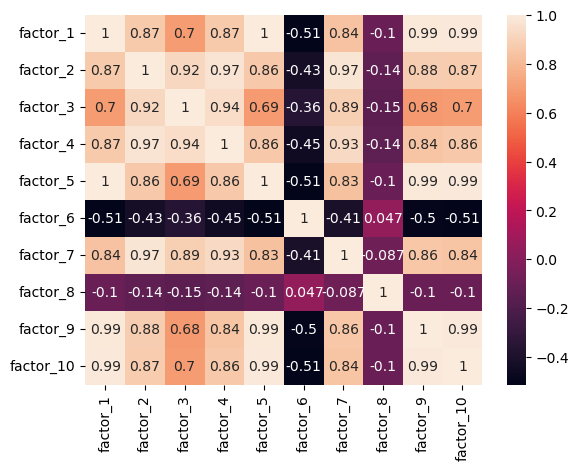

In [26]:
sns.heatmap(factors_data.corr(method='pearson'),annot=True)

Let's take a closer look at factor1, factor6 and factor8 whose correlations are low.

## show the calculation of features

In [27]:
def alpha_factor_graph(num):
    # showing the picture of features calculation

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

sub(div(Open_Lag1, Adj Close_Lag20), inv(High_Lag3))
fitness: 0.05970226022166716, depth: 2, length: 6


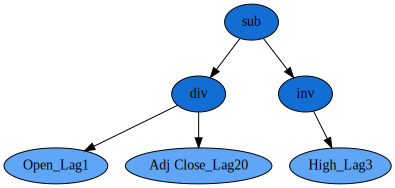

In [28]:
graph1 = alpha_factor_graph(1)
graph1

sub(inv(sub(Open_Lag20, div(Open_Lag5, Adj Close_Lag20))), inv(div(Adj Close_Lag20, High_Lag1)))
fitness: 0.05882267388824841, depth: 4, length: 11


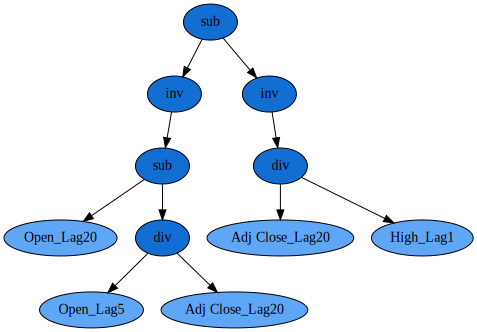

In [29]:
graph1 = alpha_factor_graph(6)
graph1

inv(div(Low_Lag5, sub(Low_Lag3, Adj Close_Lag20)))
fitness: 0.05945767554340667, depth: 3, length: 6


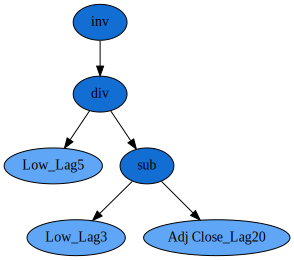

In [30]:
graph2 = alpha_factor_graph(3)
graph2

log(min(div(Open_Lag3, Adj Close_Lag20), sub(div(High_Lag3, Adj Close_Lag20), inv(High_Lag3))))
fitness: 0.05880940722558134, depth: 4, length: 11


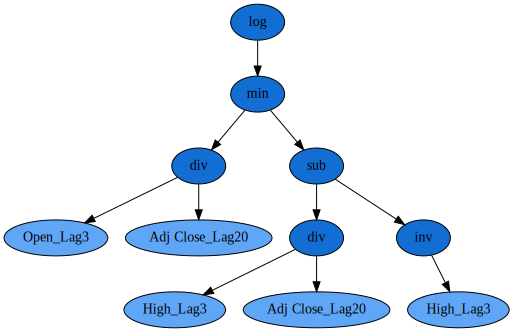

In [31]:
graph3 = alpha_factor_graph(7)
graph3

## feature calculation and analysis

In [32]:
est_gp._best_programs

In [33]:
def calculate_gpfactor_1(X):
    return est_gp._best_programs[2].execute(X.values)

def calculate_gpfactor_2(X):
    return est_gp._best_programs[5].execute(X.values)

def calculate_gpfactor_3(X):
    return est_gp._best_programs[7].execute(X.values)

In [34]:
gpfactor = pd.DataFrame(columns=['gpfactor_1','gpfactor_2','gpfactor_3'])
gpfactor['gpfactor_1'] = calculate_gpfactor_1(X_train)
gpfactor['gpfactor_2'] = calculate_gpfactor_2(X_train)
gpfactor['gpfactor_3'] = calculate_gpfactor_3(X_train)
gpfactor.head()

gpfactor_1  gpfactor_2  gpfactor_3
0    0.216588   -1.260431    0.784301
1    0.204912   -1.260939    0.786524
2    0.200687   -1.257919    0.795177
3    0.203425   -1.257950    0.795541
4    0.204649   -1.271350    0.796005

In [35]:
gpfactor.corr()

gpfactor_1  gpfactor_2  gpfactor_3
gpfactor_1    1.000000   -0.361933   -0.148478
gpfactor_2   -0.361933    1.000000    0.046902
gpfactor_3   -0.148478    0.046902    1.000000

# Factor Analysis

## extracting test data

In [36]:
if not os.path.exists('test_ohlcv.csv'):
    print("File does not exist, starting download...")
    tickers = symbols
    start = pd.to_datetime('2021-01-01')
    end = pd.to_datetime('2022-12-31')
    test_ohlcv = get(tickers, start, end)
    test_ohlcv.to_csv('test_ohlcv.csv')
else:
    print("File already exists, skipping download.")

File does not exist, starting download...



1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 00:00:00 -> 2022-12-31 00:00:00)')

1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1672462800")

1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1672462800")


## preprocess test data

In [37]:
test_ohlcv = pd.read_csv('test_ohlcv.csv')
test_ohlcv = test_ohlcv.set_index('Date')
test_ohlcv

Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2021-01-04    MMM  175.000000  176.199997  170.550003  171.869995  150.696136   
2021-01-05    MMM  172.009995  173.250000  170.649994  171.580002  150.441849   
2021-01-06    MMM  172.720001  175.570007  172.039993  174.190002  152.730347   
2021-01-07    MMM  171.559998  173.460007  166.160004  169.720001  148.810989   
2021-01-08    MMM  169.169998  169.539993  164.610001  166.619995  146.092896   
...           ...         ...         ...         ...         ...         ...   
2022-12-23    ZTS  144.509995  145.889999  143.539993  145.759995  144.442398   
2022-12-27    ZTS  145.910004  146.149994  143.570007  145.300003  143.986572   
2022-12-28    ZTS  145.179993  146.639999  143.770004  143.830002  142.529877   
2022-12-29    ZTS  145.199997  148.509995  145.139999  148.149994  146.810806   
2022-12-30    ZTS  147.199997  147.789993  144.740005  146.550003  145.225281   

               Volume  
Date                   
2021-01-04  2996200.0  
2021-01-05  2295300.0  
2021-01-06  3346400.0  
2021-01-07  5863400.0  
2021-01-08  4808100.0  
...               ...  
2022-12-23  1017900.0  
2022-12-27   957900.0  
2022-12-28  1443900.0  
2022-12-29  1298900.0  
2022-12-30  1249500.0  

[250242 rows x 7 columns]

In [38]:
test_data = gp_preprocessor().extract_original_features(test_ohlcv)
test_data

Ticker        Open        High         Low     Volume   Adj Close
Date                                                                        
2021-01-04    MMM  175.000000  176.199997  170.550003  2996200.0  150.696136
2021-01-05    MMM  172.009995  173.250000  170.649994  2295300.0  150.441849
2021-01-06    MMM  172.720001  175.570007  172.039993  3346400.0  152.730347
2021-01-07    MMM  171.559998  173.460007  166.160004  5863400.0  148.810989
2021-01-08    MMM  169.169998  169.539993  164.610001  4808100.0  146.092896
...           ...         ...         ...         ...        ...         ...
2022-12-23    ZTS  144.509995  145.889999  143.539993  1017900.0  144.442398
2022-12-27    ZTS  145.910004  146.149994  143.570007   957900.0  143.986572
2022-12-28    ZTS  145.179993  146.639999  143.770004  1443900.0  142.529877
2022-12-29    ZTS  145.199997  148.509995  145.139999  1298900.0  146.810806
2022-12-30    ZTS  147.199997  147.789993  144.740005  1249500.0  145.225281

[250242 rows x 6 columns]

In [39]:
test_data, fields = gp_preprocessor().add_lagging_features(test_data)
test_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2021-01-04    MMM  175.000000  176.199997  170.550003  2996200.0  150.696136   
2021-01-05    MMM  172.009995  173.250000  170.649994  2295300.0  150.441849   
2021-01-06    MMM  172.720001  175.570007  172.039993  3346400.0  152.730347   
2021-01-07    MMM  171.559998  173.460007  166.160004  5863400.0  148.810989   
2021-01-08    MMM  169.169998  169.539993  164.610001  4808100.0  146.092896   
...           ...         ...         ...         ...        ...         ...   
2022-12-23    ZTS  144.509995  145.889999  143.539993  1017900.0  144.442398   
2022-12-27    ZTS  145.910004  146.149994  143.570007   957900.0  143.986572   
2022-12-28    ZTS  145.179993  146.639999  143.770004  1443900.0  142.529877   
2022-12-29    ZTS  145.199997  148.509995  145.139999  1298900.0  146.810806   
2022-12-30    ZTS  147.199997  147.789993  144.740005  1249500.0  145.225281   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag1  \
Date                                                        ...                
2021-01-04         NaN         NaN         NaN         NaN  ...          NaN   
2021-01-05  175.000000         NaN         NaN         NaN  ...    2996200.0   
2021-01-06  172.009995         NaN         NaN         NaN  ...    2295300.0   
2021-01-07  172.720001  175.000000         NaN         NaN  ...    3346400.0   
2021-01-08  171.559998  172.009995         NaN         NaN  ...    5863400.0   
...                ...         ...         ...         ...  ...          ...   
2022-12-23  143.710007  142.710007  147.309998  153.940002  ...    1541800.0   
2022-12-27  144.509995  143.220001  143.839996  154.070007  ...    1017900.0   
2022-12-28  145.910004  143.710007  142.710007  158.210007  ...     957900.0   
2022-12-29  145.179993  144.509995  143.220001  153.770004  ...    1443900.0   
2022-12-30  145.199997  145.910004  143.710007  149.509995  ...    1298900.0   

            Volume_Lag3  Volume_Lag5  Volume_Lag10  Volume_Lag20  \
Date                                                               
2021-01-04          NaN          NaN           NaN           NaN   
2021-01-05          NaN          NaN           NaN           NaN   
2021-01-06          NaN          NaN           NaN           NaN   
2021-01-07    2996200.0          NaN           NaN           NaN   
2021-01-08    2295300.0          NaN           NaN           NaN   
...                 ...          ...           ...           ...   
2022-12-23    2045900.0    5216000.0     3274900.0      889500.0   
2022-12-27    1647500.0    1833700.0     1851800.0     1633300.0   
2022-12-28    1541800.0    2045900.0     3655900.0     1767100.0   
2022-12-29    1017900.0    1647500.0     2182000.0     4194100.0   
2022-12-30     957900.0    1541800.0     1947400.0     2367800.0   

            Adj Close_Lag1  Adj Close_Lag3  Adj Close_Lag5  Adj Close_Lag10  \
Date                                                                          
2021-01-04             NaN             NaN             NaN              NaN   
2021-01-05      150.696136             NaN             NaN              NaN   
2021-01-06      150.441849             NaN             NaN              NaN   
2021-01-07      152.730347      150.696136             NaN              NaN   
2021-01-08      148.810989      150.441849             NaN              NaN   
...                    ...             ...             ...              ...   
2022-12-23      143.719025      141.182144      143.154175       152.003433   
2022-12-27      144.442398      143.610001      141.895660       151.478226   
2022-12-28      143.986572      143.719025      141.182144       153.569168   
2022-12-29      142.529877      144.442398      143.610001       150.407990   
2022-12-30      146.810806      143.986572      143.719025       147.365753   

            Adj 

In [40]:
test_data = gp_preprocessor().calculate_targets(test_data)
test_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2021-01-04    MMM  175.000000  176.199997  170.550003  2996200.0  150.696136   
2021-01-05    MMM  172.009995  173.250000  170.649994  2295300.0  150.441849   
2021-01-06    MMM  172.720001  175.570007  172.039993  3346400.0  152.730347   
2021-01-07    MMM  171.559998  173.460007  166.160004  5863400.0  148.810989   
2021-01-08    MMM  169.169998  169.539993  164.610001  4808100.0  146.092896   
...           ...         ...         ...         ...        ...         ...   
2022-12-23    ZTS  144.509995  145.889999  143.539993  1017900.0  144.442398   
2022-12-27    ZTS  145.910004  146.149994  143.570007   957900.0  143.986572   
2022-12-28    ZTS  145.179993  146.639999  143.770004  1443900.0  142.529877   
2022-12-29    ZTS  145.199997  148.509995  145.139999  1298900.0  146.810806   
2022-12-30    ZTS  147.199997  147.789993  144.740005  1249500.0  145.225281   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag5  \
Date                                                        ...                
2021-01-04         NaN         NaN         NaN         NaN  ...          NaN   
2021-01-05  175.000000         NaN         NaN         NaN  ...          NaN   
2021-01-06  172.009995         NaN         NaN         NaN  ...          NaN   
2021-01-07  172.720001  175.000000         NaN         NaN  ...          NaN   
2021-01-08  171.559998  172.009995         NaN         NaN  ...          NaN   
...                ...         ...         ...         ...  ...          ...   
2022-12-23  143.710007  142.710007  147.309998  153.940002  ...    5216000.0   
2022-12-27  144.509995  143.220001  143.839996  154.070007  ...    1833700.0   
2022-12-28  145.910004  143.710007  142.710007  158.210007  ...    2045900.0   
2022-12-29  145.179993  144.509995  143.220001  153.770004  ...    1647500.0   
2022-12-30  145.199997  145.910004  143.710007  149.509995  ...    1541800.0   

            Volume_Lag10  Volume_Lag20  Adj Close_Lag1  Adj Close_Lag3  \
Date                                                                     
2021-01-04           NaN           NaN             NaN             NaN   
2021-01-05           NaN           NaN      150.696136             NaN   
2021-01-06           NaN           NaN      150.441849             NaN   
2021-01-07           NaN           NaN      152.730347      150.696136   
2021-01-08           NaN           NaN      148.810989      150.441849   
...                  ...           ...             ...             ...   
2022-12-23     3274900.0      889500.0      143.719025      141.182144   
2022-12-27     1851800.0     1633300.0      144.442398      143.610001   
2022-12-28     3655900.0     1767100.0      143.986572      143.719025   
2022-12-29     2182000.0     4194100.0      142.529877      144.442398   
2022-12-30     1947400.0     2367800.0      146.810806      143.986572   

            Adj Close_Lag5  Adj Close_Lag10  Adj Close_Lag20  \
Date                                                           
2021-01-04             NaN              NaN              NaN   
2021-01-05             NaN              NaN              NaN   
2021-01-06             NaN              NaN              NaN   
2021-01-07             NaN              NaN              NaN   
2021-01-08             NaN              NaN              NaN   
...                    ...              ...              ...   
2022-12-23      143.154175       152.003433       148.743179   
2022-12-27      141.895660       151.478226       146.790985   
2022-12-28      141.182144       153.569168       146.513519   
2022-12-29      143.610001       150.407990       152.746674   
2022-12-30      143.719025       147.365753       155.224060   

            Future_20d_Adj Close  Future_20d_Return  
Date                                                 
2021-01-04            144

In [41]:
test_data.dropna(axis=0, how='any',inplace=True)
test_data

Ticker        Open        High         Low     Volume   Adj Close  \
Date                                                                           
2021-02-02    MMM  176.250000  177.529999  174.850006  2844400.0  153.458069   
2021-02-03    MMM  175.380005  177.440002  173.550003  2874200.0  153.861374   
2021-02-04    MMM  175.789993  177.289993  175.509995  1833000.0  155.281815   
2021-02-05    MMM  177.600006  179.229996  176.699997  1822400.0  156.956497   
2021-02-08    MMM  179.300003  180.869995  179.169998  2355100.0  158.490891   
...           ...         ...         ...         ...        ...         ...   
2022-12-16    ZTS  147.309998  147.570007  143.919998  5216000.0  143.154175   
2022-12-19    ZTS  143.839996  144.440002  142.009995  1833700.0  141.895660   
2022-12-20    ZTS  142.710007  143.100006  140.759995  2045900.0  141.182144   
2022-12-21    ZTS  143.220001  146.149994  142.779999  1647500.0  143.610001   
2022-12-22    ZTS  143.710007  145.100006  141.850006  1541800.0  143.719025   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  ...  Volume_Lag5  \
Date                                                        ...                
2021-02-02  175.970001  185.000000  173.779999  167.259995  ...    5148900.0   
2021-02-03  176.250000  182.289993  177.309998  169.039993  ...    8097000.0   
2021-02-04  175.380005  175.970001  185.000000  170.220001  ...    4153700.0   
2021-02-05  175.789993  176.250000  182.289993  170.199997  ...    4217200.0   
2021-02-08  177.600006  175.380005  175.970001  168.880005  ...    2569700.0   
...                ...         ...         ...         ...  ...          ...   
2022-12-16  149.509995  158.210007  153.940002  154.110001  ...    3274900.0   
2022-12-19  147.309998  153.770004  154.070007  155.630005  ...    1851800.0   
2022-12-20  143.839996  149.509995  158.210007  154.220001  ...    3655900.0   
2022-12-21  142.710007  147.309998  153.770004  152.960007  ...    2182000.0   
2022-12-22  143.220001  143.839996  149.509995  150.529999  ...    1947400.0   

            Volume_Lag10  Volume_Lag20  Adj Close_Lag1  Adj Close_Lag3  \
Date                                                                     
2021-02-02     3903200.0     2996200.0      153.177460      160.823181   
2021-02-03     2672300.0     2295300.0      153.458069      154.019241   
2021-02-04     2688200.0     3346400.0      153.861374      153.177460   
2021-02-05     2349300.0     5863400.0      155.281815      153.458069   
2021-02-08     3353100.0     4808100.0      156.956497      153.861374   
...                  ...           ...             ...             ...   
2022-12-16     1946100.0     2816800.0      147.365753      153.569168   
2022-12-19     2087400.0     2410500.0      143.154175      150.407990   
2022-12-20     1964800.0     1998900.0      141.895660      147.365753   
2022-12-21     2444100.0     1628500.0      141.182144      143.154175   
2022-12-22     2267500.0     1445900.0      143.610001      141.895660   

            Adj Close_Lag5  Adj Close_Lag10  Adj Close_Lag20  \
Date                                                           
2021-02-02      154.273483       148.284897       150.696136   
2021-02-03      163.655258       149.249405       150.441849   
2021-02-04      160.823181       149.643982       152.730347   
2021-02-05      154.019241       148.214767       148.810989   
2021-02-08      153.177460       149.398453       146.092896   
...                    ...              ...              ...   
2022-12-16      152.003433       155.997009       142.301956   
2022-12-19      151.478226       153.925903       144.323502   
2022-12-20      153.569168       151.666519       145.998230   
2022-12-21      150.407990       148.891830       147.286469   
2022-12-22      147.365753       152.290833       149.109833   

            Future_20d_Adj Close  Future_20d_Return  
Date                                                 
2021-02-02            158

In [42]:
X_test = test_data.loc[:,fields]
X_test

Open        High         Low     Volume   Adj Close  \
Date                                                                    
2021-02-02  176.250000  177.529999  174.850006  2844400.0  153.458069   
2021-02-03  175.380005  177.440002  173.550003  2874200.0  153.861374   
2021-02-04  175.789993  177.289993  175.509995  1833000.0  155.281815   
2021-02-05  177.600006  179.229996  176.699997  1822400.0  156.956497   
2021-02-08  179.300003  180.869995  179.169998  2355100.0  158.490891   
...                ...         ...         ...        ...         ...   
2022-12-16  147.309998  147.570007  143.919998  5216000.0  143.154175   
2022-12-19  143.839996  144.440002  142.009995  1833700.0  141.895660   
2022-12-20  142.710007  143.100006  140.759995  2045900.0  141.182144   
2022-12-21  143.220001  146.149994  142.779999  1647500.0  143.610001   
2022-12-22  143.710007  145.100006  141.850006  1541800.0  143.719025   

             Open_Lag1   Open_Lag3   Open_Lag5  Open_Lag10  Open_Lag20  ...  \
Date                                                                    ...   
2021-02-02  175.970001  185.000000  173.779999  167.259995  175.000000  ...   
2021-02-03  176.250000  182.289993  177.309998  169.039993  172.009995  ...   
2021-02-04  175.380005  175.970001  185.000000  170.220001  172.720001  ...   
2021-02-05  175.789993  176.250000  182.289993  170.199997  171.559998  ...   
2021-02-08  177.600006  175.380005  175.970001  168.880005  169.169998  ...   
...                ...         ...         ...         ...         ...  ...   
2022-12-16  149.509995  158.210007  153.940002  154.110001  146.600006  ...   
2022-12-19  147.309998  153.770004  154.070007  155.630005  146.130005  ...   
2022-12-20  143.839996  149.509995  158.210007  154.220001  145.330002  ...   
2022-12-21  142.710007  147.309998  153.770004  152.960007  148.089996  ...   
2022-12-22  143.220001  143.839996  149.509995  150.529999  148.699997  ...   

            Volume_Lag1  Volume_Lag3  Volume_Lag5  Volume_Lag10  Volume_Lag20  \
Date                                                                            
2021-02-02    2569700.0    4153700.0    5148900.0     3903200.0     2996200.0   
2021-02-03    2844400.0    4217200.0    8097000.0     2672300.0     2295300.0   
2021-02-04    2874200.0    2569700.0    4153700.0     2688200.0     3346400.0   
2021-02-05    1833000.0    2844400.0    4217200.0     2349300.0     5863400.0   
2021-02-08    1822400.0    2874200.0    2569700.0     3353100.0     4808100.0   
...                 ...          ...          ...           ...           ...   
2022-12-16    1947400.0    3655900.0    3274900.0     1946100.0     2816800.0   
2022-12-19    5216000.0    2182000.0    1851800.0     2087400.0     2410500.0   
2022-12-20    1833700.0    1947400.0    3655900.0     1964800.0     1998900.0   
2022-12-21    2045900.0    5216000.0    2182000.0     2444100.0     1628500.0   
2022-12-22    1647500.0    1833700.0    1947400.0     2267500.0     1445900.0   

            Adj Close_Lag1  Adj Close_Lag3  Adj Close_Lag5  Adj Close_Lag10  \
Date                                                                          
2021-02-02      153.177460      160.823181      154.273483       148.284897   
2021-02-03      153.458069      154.019241      163.655258       149.249405   
2021-02-04      153.861374      153.177460      160.823181       149.643982   
2021-02-05      155.281815      153.458069      154.019241       148.214767   
2021-02-08      156.956497      153.861374      153.177460       149.398453   
...                    ...             ...             ...              ...   
2022-12-16      147.365753      153.569168      152.003433       155.997009   
2022-12-19      143.154175      150.407990      151.478226       153.925903   
2022-12-20      141.895660      147.365753      153.569168       151.666519   
2022-12-21      141.182144      143.154175      150.407990       148.891830   
2022-12-22      143.610001      141.89

## factor calculation

In [43]:
gpfactor_test = pd.DataFrame(columns=['gpfactor_1','gpfactor_2','gpfactor_3'])
gpfactor_test['gpfactor_1'] = calculate_gpfactor_1(X_test)
gpfactor_test['gpfactor_2'] = calculate_gpfactor_2(X_test)
gpfactor_test['gpfactor_3'] = calculate_gpfactor_3(X_test)
gpfactor_test.index = test_data.index
gpfactor_test['Ticker'] = test_data['Ticker']
gpfactor_test['Open'] = test_data['Open']
gpfactor_test.reset_index(inplace=True)
gpfactor_test['Date'] = pd.to_datetime(gpfactor_test['Date'])
gpfactor_test.set_index(['Date','Ticker'],inplace=True)
gpfactor_test.sort_index(inplace=True)
gpfactor_test

gpfactor_1  gpfactor_2  gpfactor_3        Open
Date       Ticker                                                
2021-02-02 A         0.017748   -1.038765    0.987564  122.500000
           AAL       0.110241   -1.077949    0.770563   17.030001
           AAPL      0.067453   -1.057055    0.917329  135.729996
           ABBV      0.092628   -1.107010    0.902432  102.879997
           ABNB      0.270164   -1.350273    0.689045  183.220001
...                       ...         ...         ...         ...
2022-12-22 YUM       0.027413   -1.037314    0.969068  128.500000
           ZBH       0.056980   -1.076690    0.941441  126.449997
           ZBRA     -0.111276   -0.933888    1.091705  245.779999
           ZION     -0.082787   -0.949845    1.089241   47.259998
           ZTS      -0.047797   -0.973379    1.044130  143.710007

[237781 rows x 4 columns]

In [44]:
gpfactor_test.loc[:,['gpfactor_1','gpfactor_2','gpfactor_3']].corr()

gpfactor_1  gpfactor_2  gpfactor_3
gpfactor_1    1.000000   -0.911617   -0.971095
gpfactor_2   -0.911617    1.000000    0.917510
gpfactor_3   -0.971095    0.917510    1.000000

## Factor 1

In [45]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_returns_tear_sheet

In [46]:
gpfactor1 = gpfactor_test['gpfactor_1']
gpfactor2 = gpfactor_test['gpfactor_2']
gpfactor3 = gpfactor_test['gpfactor_3']
gpfactor1

Date        Ticker
2021-02-02  A         0.017748
            AAL       0.110241
            AAPL      0.067453
            ABBV      0.092628
            ABNB      0.270164
                        ...   
2022-12-22  YUM       0.027413
            ZBH       0.056980
            ZBRA     -0.111276
            ZION     -0.082787
            ZTS      -0.047797
Name: gpfactor_1, Length: 237781, dtype: float64

In [47]:
trade_prices = gpfactor_test.reset_index().set_index('Date').sort_index().pivot(columns='Ticker',values='Open').sort_index().shift(-1)
trade_prices

Ticker               A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2021-02-02  123.500000  16.610001  135.759995  106.199997  181.979996   
2021-02-03  122.510002  17.480000  136.300003  106.870003  187.070007   
2021-02-04  124.510002  17.600000  137.350006  109.629997  197.000000   
2021-02-05  123.919998  17.320000  136.029999  108.889999  199.929993   
2021-02-08  123.410004  17.740000  136.619995  106.000000  199.203003   
...                ...        ...         ...         ...         ...   
2022-12-16  148.910004  12.850000  135.110001  160.779999   89.510002   
2022-12-19  147.270004  12.420000  131.389999  161.610001   86.709999   
2022-12-20  148.940002  12.690000  132.979996  161.449997   87.489998   
2022-12-21  148.410004  12.980000  134.350006  161.869995   85.540001   
2022-12-22         NaN        NaN         NaN         NaN         NaN   

Ticker             ABT       ACGL         ACN        ADBE         ADI  ...  \
Date                                                                   ...   
2021-02-02  119.739998  33.099998  248.190002  487.089996  152.000000  ...   
2021-02-03  119.830002  32.799999  249.559998  484.220001  147.830002  ...   
2021-02-04  120.430000  33.740002  254.089996  490.920013  151.720001  ...   
2021-02-05  125.000000  33.889999  253.919998  494.260010  150.160004  ...   
2021-02-08  124.830002  34.299999  256.309998  495.000000  152.699997  ...   
...                ...        ...         ...         ...         ...  ...   
2022-12-16  106.739998  60.880001  263.160004  338.000000  167.440002  ...   
2022-12-19  106.610001  61.730000  253.740005  327.000000  163.720001  ...   
2022-12-20  107.089996  62.450001  264.480011  340.290009  165.380005  ...   
2022-12-21  107.709999  63.090000  264.440002  336.010010  164.830002  ...   
2022-12-22         NaN        NaN         NaN         NaN         NaN  ...   

Ticker            WYNN        XEL         XOM       XRAY         XYL  \
Date                                                                   
2021-02-02  106.699997  64.089996   45.630001  54.830002   97.000000   
2021-02-03  109.279999  63.080002   47.880001  54.889999   97.690002   
2021-02-04  112.080002  63.790001   49.180000  56.169998   96.940002   
2021-02-05  114.849998  63.419998   50.919998  55.410000   98.419998   
2021-02-08  115.800003  62.610001   50.669998  55.720001  101.059998   
...                ...        ...         ...        ...         ...   
2022-12-16   84.830002  69.930000  105.260002  30.370001  109.459999   
2022-12-19   81.339996  69.489998  105.169998  30.459999  108.300003   
2022-12-20   83.250000  69.709999  108.290001  31.209999  109.160004   
2022-12-21   82.050003  70.120003  107.889999  31.160000  109.930000   
2022-12-22         NaN        NaN         NaN        NaN         NaN   

Ticker             YUM         ZBH        ZBRA       ZION         ZTS  
Date                                                                   
2021-02-02  105.790001  153.184464  411.000000  45.590000  157.320007  
2021-02-03  105.440002  155.262131  404.470001  46.400002  155.350006  
2021-02-04  103.349998  165.097092  409.269989  48.630001  157.889999  
2021-02-05  104.820000  155.504852  411.959991  48.150002  160.399994  
2021-02-08  103.410004  155.145630  419.519989  49.110001  159.809998  
...                ...         ...         ...        ...         ...  
2022-12-16  129.110001  125.330002  249.000000  46.099998  143.839996  
2022-12-19  128.520004  124.959999  242.550003  45.950001  142.710007  
2022-12-20  128.130005  126.489998  248.610001  47.029999  143.220001  
2022-12-21  128.500000  126.449997  245.779999  47.259998  143.710007  
2022-12-22         NaN         NaN         NaN        NaN         NaN  

[478 rows x 498 columns]

In [48]:
gpfactor1_formatted = get_clean_factor_and_forward_returns(factor=gpfactor1,  # using prediction as factor of the whole model
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))

Dropped 4.4% entries from factor data: 4.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [49]:
gpfactor1_formatted

1D        5D       10D       21D    factor  \
date       asset                                                     
2021-02-02 A     -0.008016  0.008826  0.044534 -0.061700  0.017748   
           AAL    0.052378  0.056592  0.073450  0.288380  0.110241   
           AAPL   0.003978  0.005303 -0.048321 -0.108869  0.067453   
           ABBV   0.006309 -0.002072 -0.008286 -0.001789  0.092628   
           ABNB   0.027970  0.129135  0.093582  0.002967  0.270164   
...                    ...       ...       ...       ...       ...   
2022-11-22 YUM    0.002070  0.027070  0.026354  0.023089  0.103194   
           ZBH    0.017874  0.039701  0.072098  0.086620  0.016596   
           ZBRA   0.029535  0.022912 -0.039697 -0.064550 -0.094764   
           ZION   0.007231  0.020129 -0.074653 -0.076412  0.021343   
           ZTS    0.011903  0.049092  0.012307 -0.033557 -0.053230   

                  factor_quantile  
date       asset                   
2021-02-02 A                    2  
           AAL                  4  
           AAPL                 3  
           ABBV                 4  
           ABNB                 5  
...                           ...  
2022-11-22 YUM                  5  
           ZBH                  2  
           ZBRA                 1  
           ZION                 2  
           ZTS                  1  

[227323 rows x 6 columns]

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -1.531666  0.064131 -0.088546  0.093653  45700  20.103553
2               -0.200214  0.105979 -0.008286  0.052099  45243  19.902518
3               -0.131076  0.146435  0.028867  0.047617  45437  19.987859
4               -0.084803  0.190418  0.063521  0.045583  45243  19.902518
5               -0.045221  1.000000  0.122180  0.062964  45700  20.103553

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                     0.003  0.011  0.007 -0.002
beta                                          -0.191 -0.173 -0.171 -0.172
Mean Period Wise Return Top Quantile (bps)    -0.922 -0.273 -0.742 -1.431
Mean Period Wise Return Bottom Quantile (bps)  0.408  0.095  0.261  0.458
Mean Period Wise Spread (bps)                 -1.330 -0.329 -0.981 -1.898

Information Analysis


1D     5D    10D    21D
IC Mean          -0.002 -0.007 -0.011 -0.026
IC Std.           0.214  0.200  0.194  0.195
Risk-Adjusted IC -0.008 -0.034 -0.056 -0.134
t-stat(IC)       -0.175 -0.734 -1.195 -2.872
p-value(IC)       0.861  0.463  0.233  0.004
IC Skew          -0.009 -0.093 -0.219 -0.165
IC Kurtosis      -0.017 -0.215 -0.228 -0.283

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.155  0.363  0.519  0.687
Quantile 2 Mean Turnover   0.353  0.622  0.714  0.769
Quantile 3 Mean Turnover   0.400  0.655  0.739  0.779
Quantile 4 Mean Turnover   0.361  0.622  0.713  0.761
Quantile 5 Mean Turnover   0.166  0.379  0.532  0.687

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.942  0.735  0.512  0.217

<Figure size 640x480 with 0 Axes>

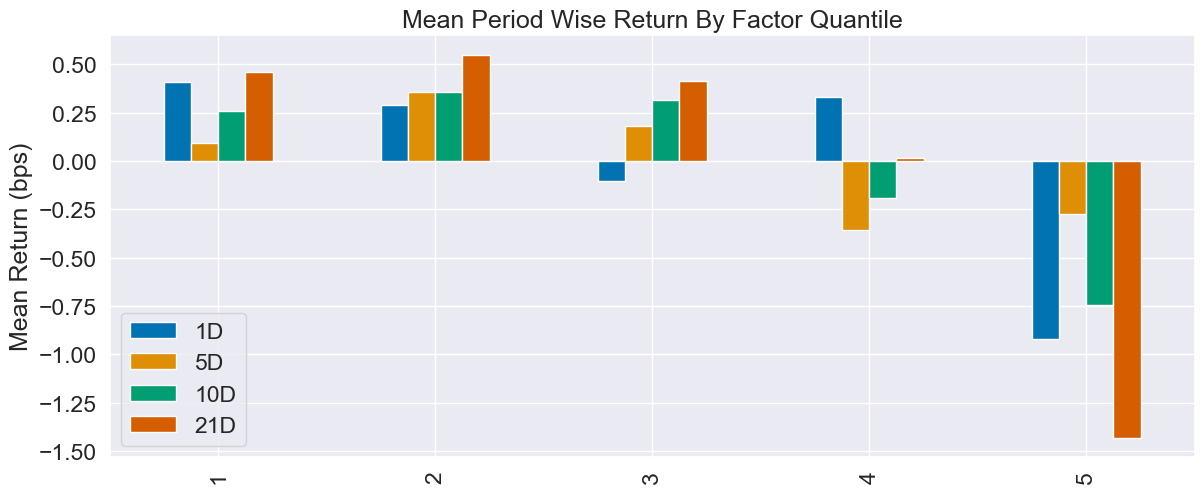

In [50]:
create_summary_tear_sheet(gpfactor1_formatted)

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                     0.003  0.011  0.007 -0.002
beta                                          -0.191 -0.173 -0.171 -0.172
Mean Period Wise Return Top Quantile (bps)    -0.922 -0.273 -0.742 -1.431
Mean Period Wise Return Bottom Quantile (bps)  0.408  0.095  0.261  0.458
Mean Period Wise Spread (bps)                 -1.330 -0.329 -0.981 -1.898

<Figure size 640x480 with 0 Axes>

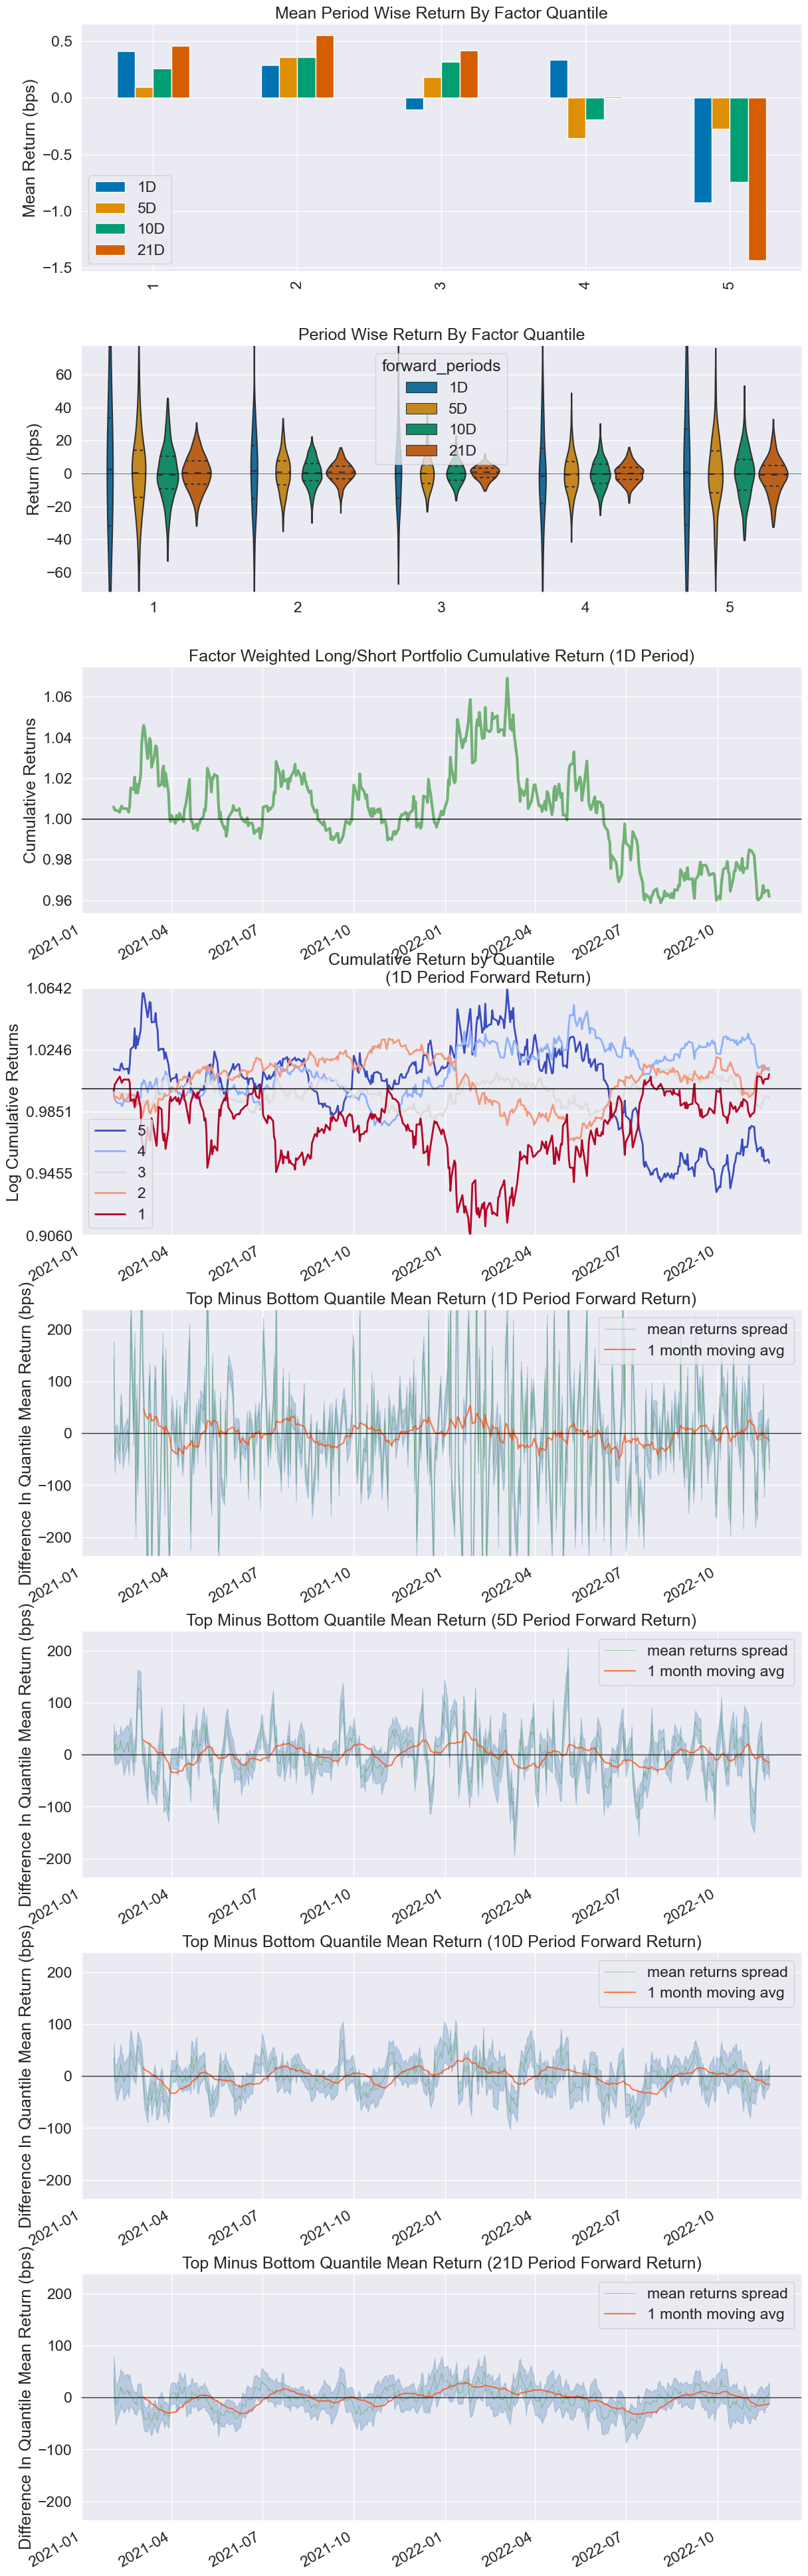

In [51]:
create_returns_tear_sheet(gpfactor1_formatted,
                                   long_short=True,)

## Factor 2

In [52]:
gpfactor2_formatted = get_clean_factor_and_forward_returns(factor=gpfactor2,  # using prediction as factor of the whole model
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))

Dropped 4.4% entries from factor data: 4.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -2.095546 -0.971021 -1.161321  0.082383  45700  20.103553
2               -1.264348 -0.927421 -1.084269  0.051428  45243  19.902518
3               -1.174856 -0.897969 -1.045034  0.049475  45437  19.987859
4               -1.134856 -0.855507 -1.006428  0.049619  45243  19.902518
5               -1.077393 -0.415131 -0.934844  0.069437  45700  20.103553

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                    -0.007 -0.000  0.001  0.015
beta                                           0.167  0.154  0.142  0.151
Mean Period Wise Return Top Quantile (bps)     0.699  0.759  0.625  0.985
Mean Period Wise Return Bottom Quantile (bps) -0.403 -0.334 -0.661 -1.557
Mean Period Wise Spread (bps)                  1.101  1.060  1.267  2.553

Information Analysis


1D     5D    10D    21D
IC Mean           0.002  0.009  0.012  0.031
IC Std.           0.212  0.196  0.186  0.185
Risk-Adjusted IC  0.009  0.047  0.065  0.169
t-stat(IC)        0.189  1.004  1.397  3.618
p-value(IC)       0.851  0.316  0.163  0.000
IC Skew           0.061  0.076  0.245  0.145
IC Kurtosis      -0.041 -0.162 -0.021 -0.237

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.158  0.364  0.516  0.712
Quantile 2 Mean Turnover   0.352  0.613  0.708  0.768
Quantile 3 Mean Turnover   0.391  0.651  0.733  0.782
Quantile 4 Mean Turnover   0.344  0.610  0.705  0.776
Quantile 5 Mean Turnover   0.151  0.353  0.507  0.710

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.948  0.751  0.532  0.165

<Figure size 640x480 with 0 Axes>

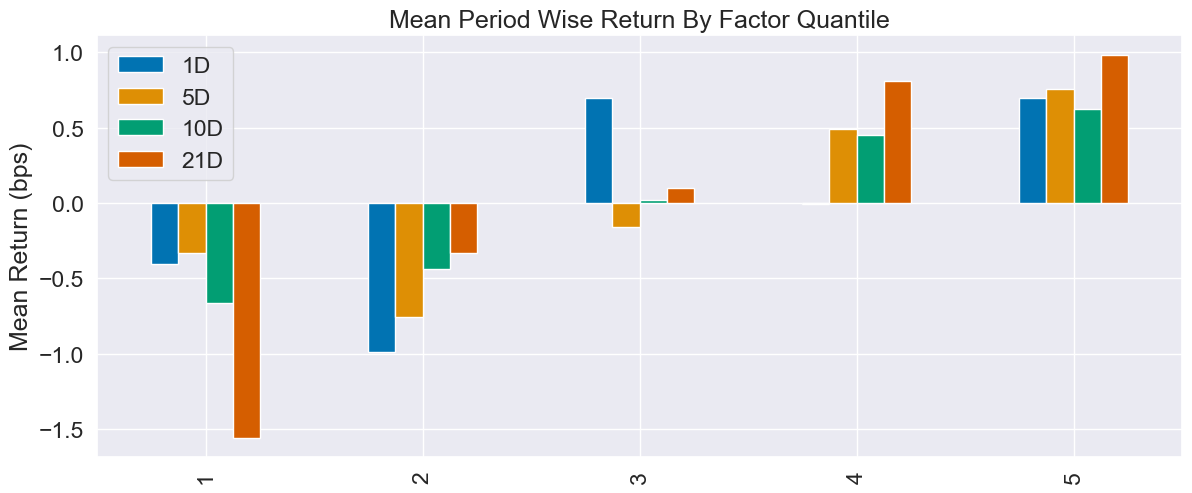

In [53]:
create_summary_tear_sheet(gpfactor2_formatted)

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                    -0.007 -0.000  0.001  0.015
beta                                           0.167  0.154  0.142  0.151
Mean Period Wise Return Top Quantile (bps)     0.699  0.759  0.625  0.985
Mean Period Wise Return Bottom Quantile (bps) -0.403 -0.334 -0.661 -1.557
Mean Period Wise Spread (bps)                  1.101  1.060  1.267  2.553

<Figure size 640x480 with 0 Axes>

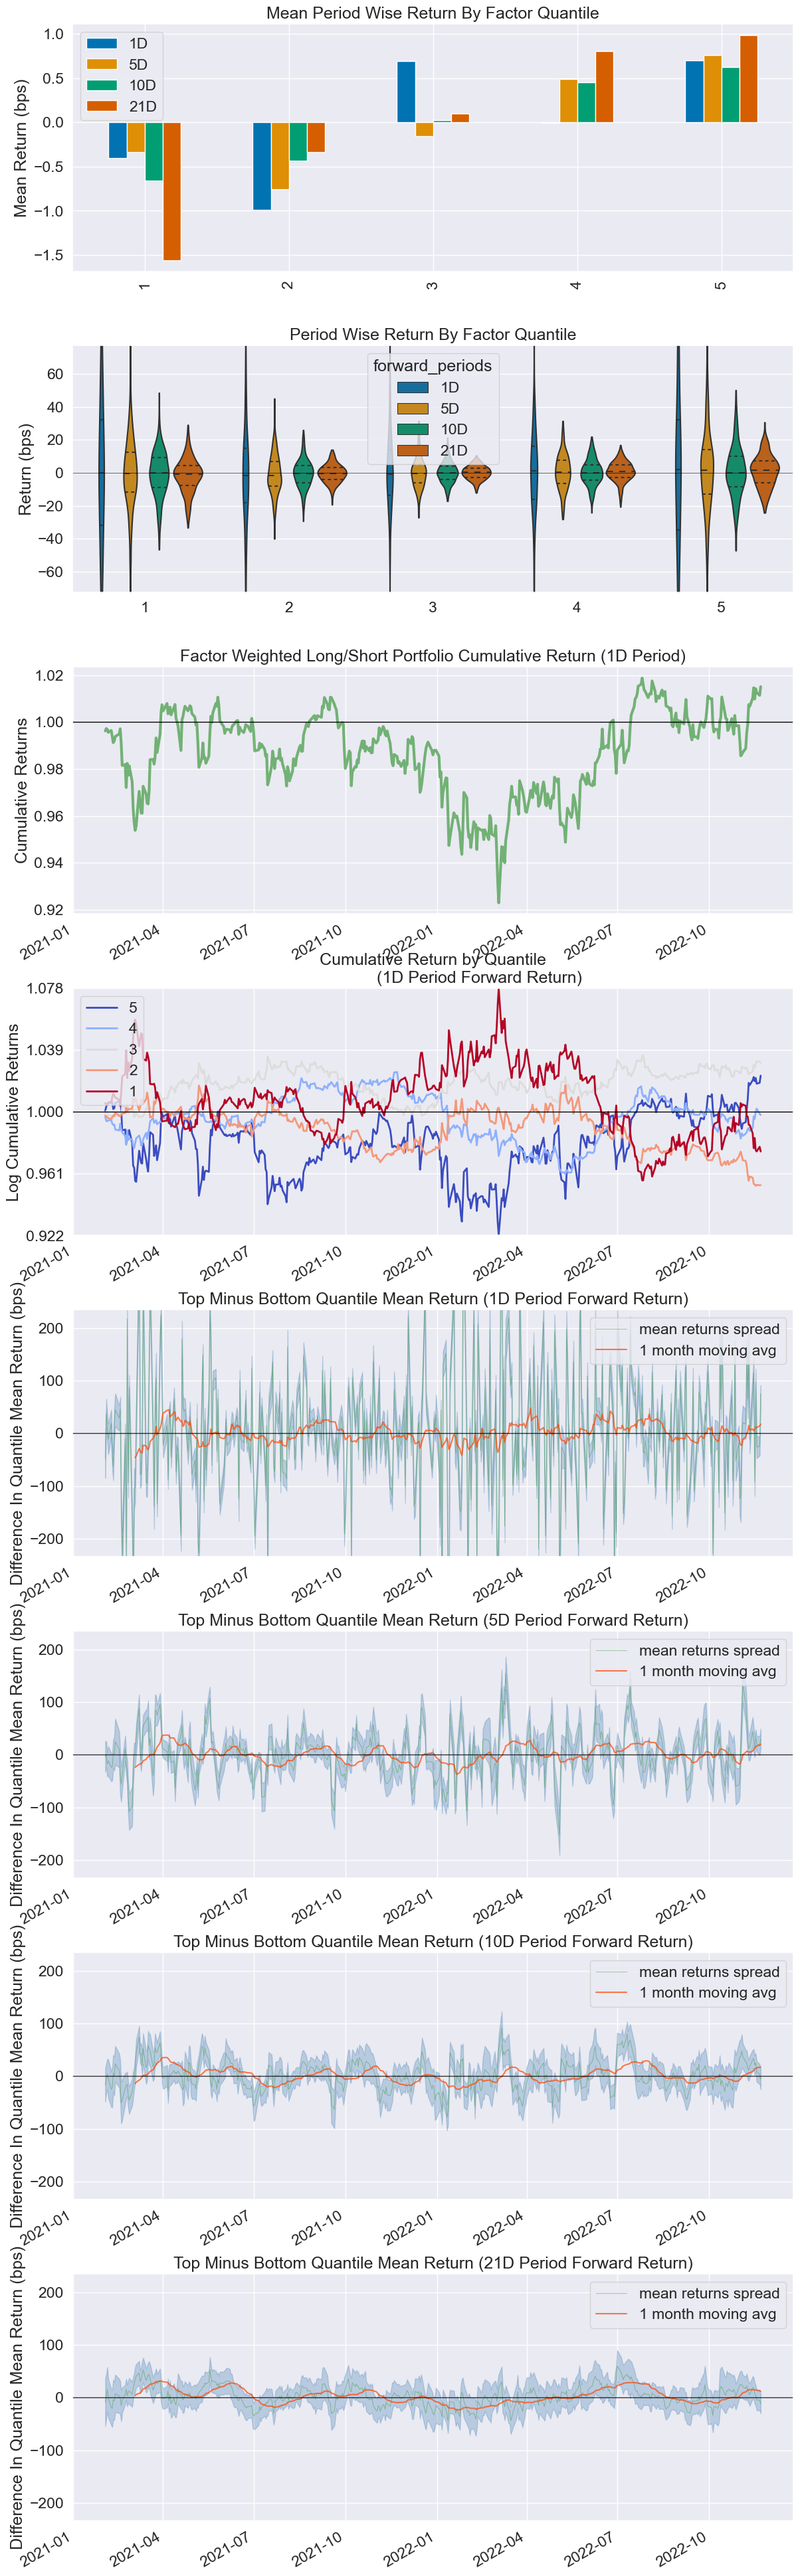

In [54]:
create_returns_tear_sheet(gpfactor2_formatted,
                                   long_short=True,)

## Factor 3

In [55]:
gpfactor3_formatted = get_clean_factor_and_forward_returns(factor=gpfactor3,  # using prediction as factor of the whole model
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))

Dropped 4.4% entries from factor data: 4.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1                0.574671  1.048614  0.880209  0.056108  45700  20.103553
2                0.812289  1.086150  0.937112  0.044199  45243  19.902518
3                0.860474  1.129683  0.971022  0.046590  45437  19.987859
4                0.894153  1.202631  1.007132  0.051078  45243  19.902518
5                0.936181  2.720895  1.087822  0.095350  45700  20.103553

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                     0.007  0.000  0.006  0.013
beta                                           0.174  0.162  0.164  0.167
Mean Period Wise Return Top Quantile (bps)     1.178  0.827  1.076  1.133
Mean Period Wise Return Bottom Quantile (bps) -1.071 -0.273 -0.881 -1.682
Mean Period Wise Spread (bps)                  2.249  1.068  1.938  2.827

Information Analysis


1D     5D    10D    21D
IC Mean           0.002  0.008  0.014  0.032
IC Std.           0.205  0.189  0.184  0.187
Risk-Adjusted IC  0.012  0.041  0.078  0.173
t-stat(IC)        0.247  0.885  1.664  3.695
p-value(IC)       0.805  0.377  0.097  0.000
IC Skew           0.052  0.127  0.210  0.100
IC Kurtosis       0.024 -0.104 -0.137 -0.279

Turnover Analysis


1D     5D    10D    21D
Quantile 1 Mean Turnover   0.173  0.388  0.546  0.697
Quantile 2 Mean Turnover   0.377  0.632  0.724  0.765
Quantile 3 Mean Turnover   0.421  0.663  0.745  0.778
Quantile 4 Mean Turnover   0.373  0.631  0.722  0.773
Quantile 5 Mean Turnover   0.164  0.374  0.533  0.692

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.938  0.721  0.486  0.193

<Figure size 640x480 with 0 Axes>

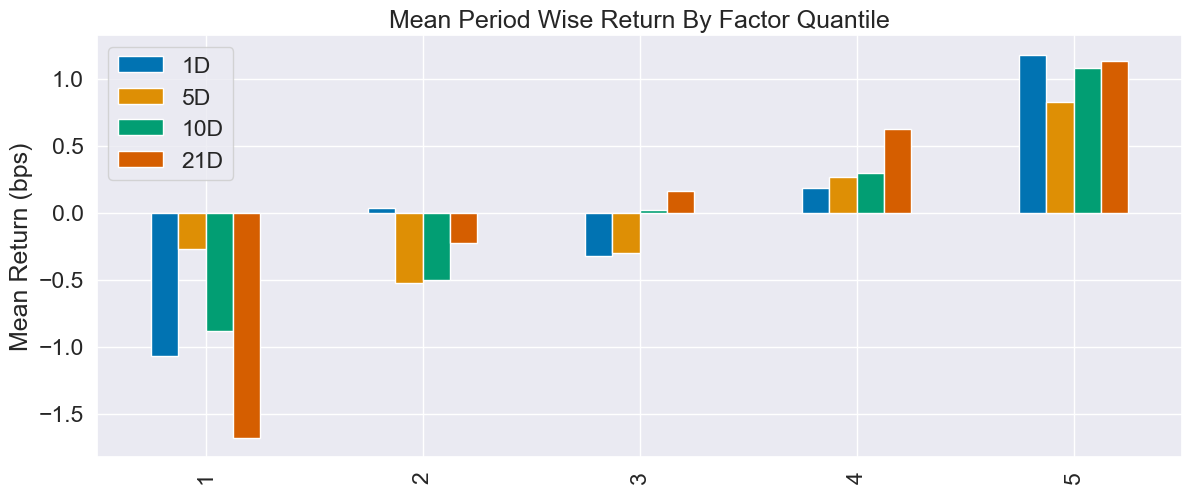

In [56]:
create_summary_tear_sheet(gpfactor3_formatted)

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                     0.007  0.000  0.006  0.013
beta                                           0.174  0.162  0.164  0.167
Mean Period Wise Return Top Quantile (bps)     1.178  0.827  1.076  1.133
Mean Period Wise Return Bottom Quantile (bps) -1.071 -0.273 -0.881 -1.682
Mean Period Wise Spread (bps)                  2.249  1.068  1.938  2.827

<Figure size 640x480 with 0 Axes>

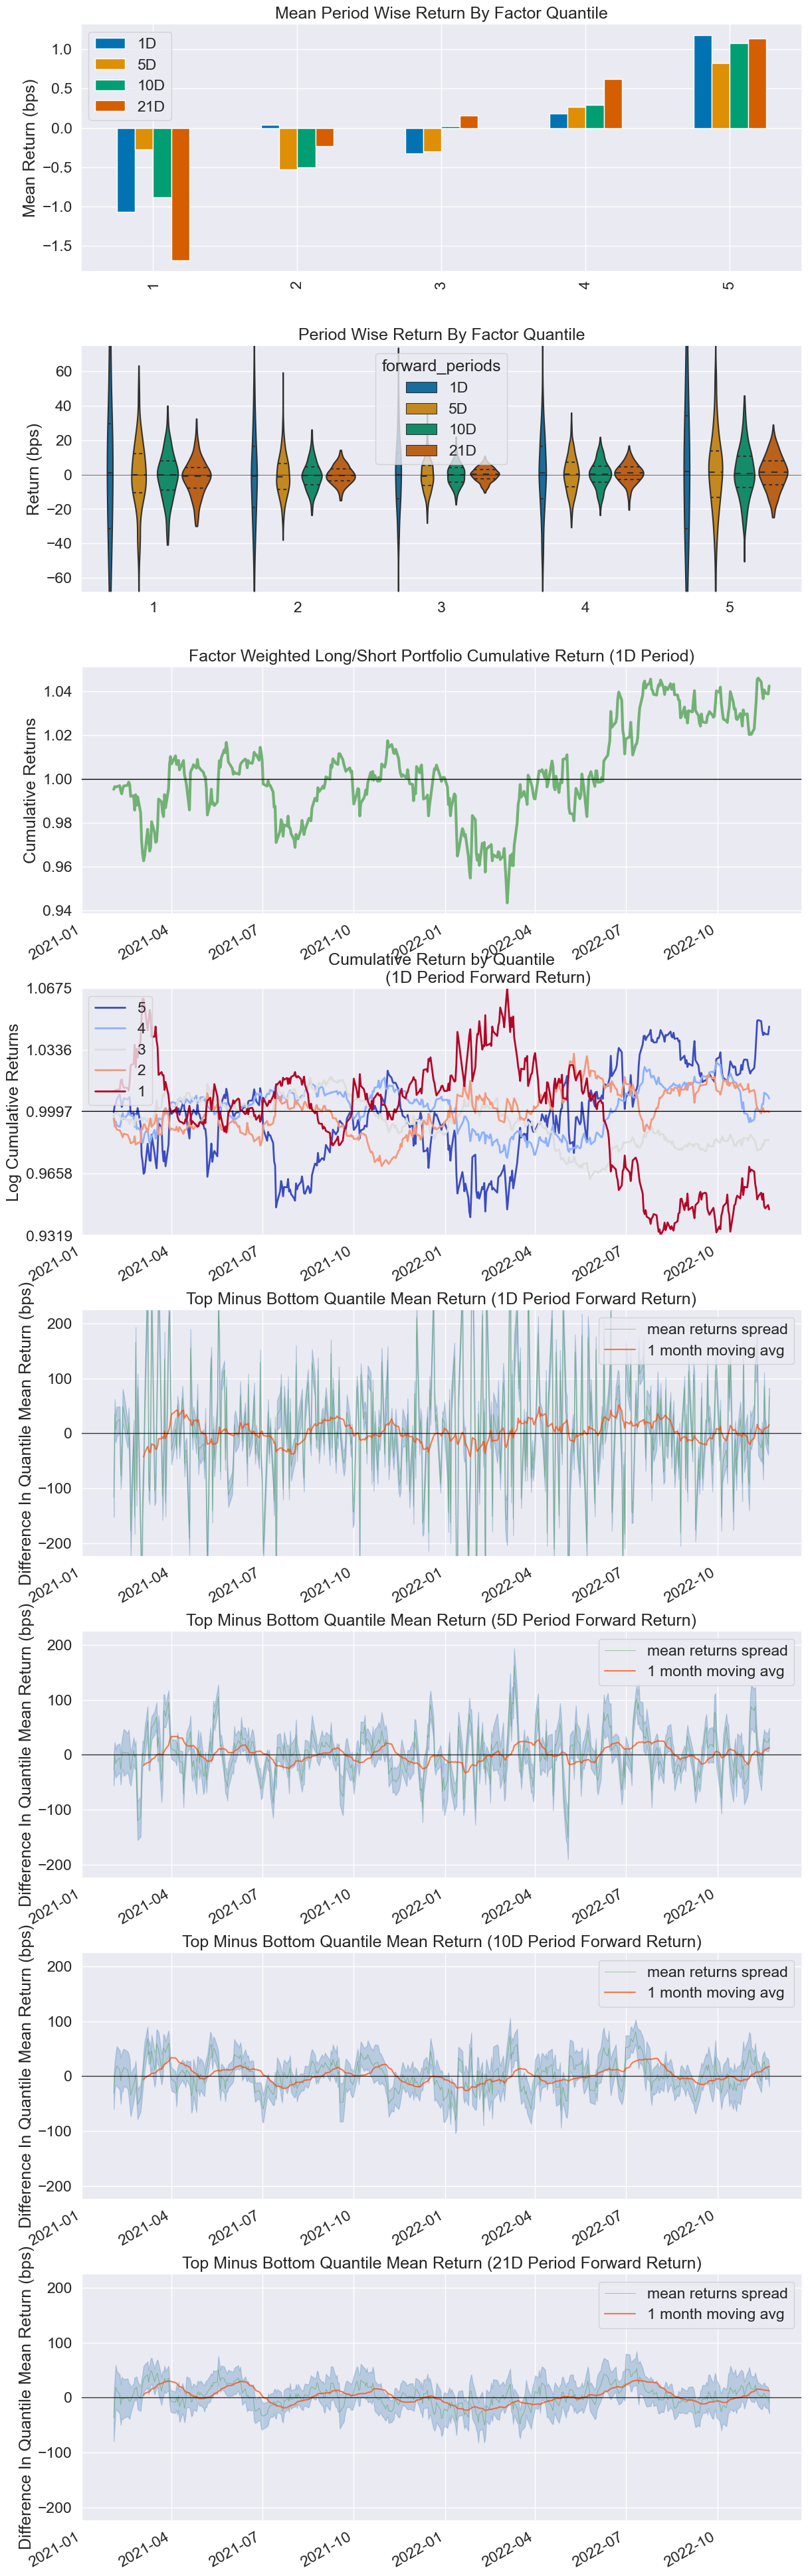

In [57]:
create_returns_tear_sheet(gpfactor3_formatted,
                                   long_short=True,)